In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
image_size=896
batch_size=32
channels=3
epochs=50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
"Leaves",
shuffle=True,
image_size = (image_size,image_size),
batch_size = batch_size)

Found 3000 files belonging to 4 classes.


In [3]:
class_names = dataset.class_names
class_names

['Bug', 'Dubas', 'Healthy', 'Honey']

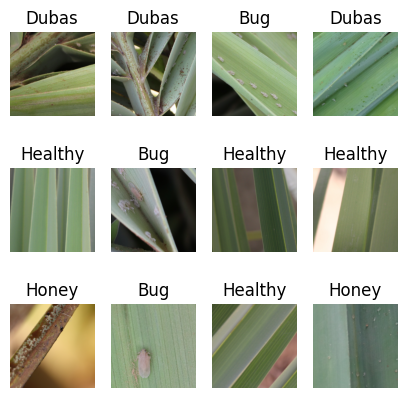

In [5]:
plt.figure(figsize=(5,5))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 896, 896, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 894, 894, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 447, 447, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 445, 445, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 222, 222, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 220, 220, 64)       

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
model.save('iot_model.h5')

In [ ]:
modelv = 1
model.save(f"../models/{modelv}")